<a href="https://colab.research.google.com/github/LEEJIYOUNG245/covid19/blob/main/vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset,DataLoader

import cv2
import math
import shutil
import random
import glob
import time, copy
import numpy as np

from PIL import Image
from pathlib import Path
from matplotlib import pyplot as plt

import os
from os import listdir
from os.path import isfile, join

# **파일Path 작업**

In [ ]:
PATH = "/content/gdrive/MyDrive/개인/CT_DATA_SPLITTED"
Folder = os.listdir(PATH)

train_path = []
val_path = []
test_path = []
li =[train_path, val_path, test_path]

for index, folder in enumerate(Folder):
  folder_path = os.path.join(PATH,folder)
  file_path = os.listdir(folder_path)
  file_list = []
  for filename in file_path:
    file_path = os.path.join(folder_path, filename)
    file_list.append(file_path)
  li[index] += file_list

In [ ]:
print(len(train_path),len(val_path),len(test_path))

447 148 148


# **label별 분포도 출력**

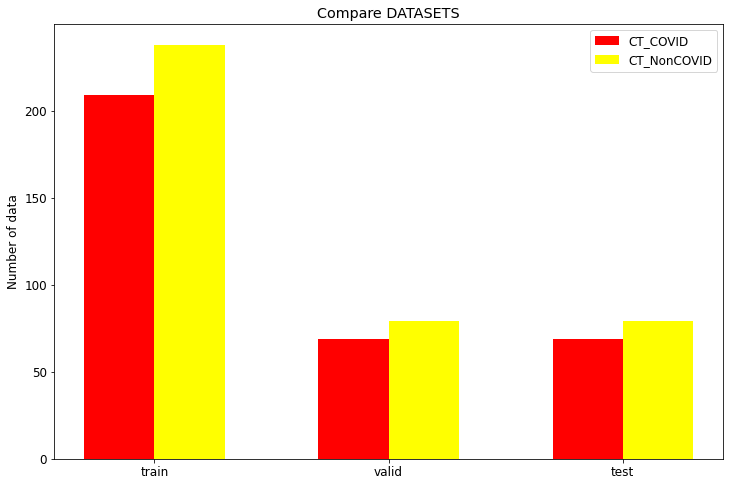

In [ ]:
#label별 count
class compare_covid_dataset():
    def __init__(self,li):
        self.li = li
        self.cnt_li = [[0,0],[0,0],[0,0]]

        for index, folder in enumerate(li):
            for i in folder:
                if 'CT_COVID' in i:
                    self.cnt_li[index][0]+=1
                else:
                    self.cnt_li[index][1]+=1

        self.train_cat_cnt = self.cnt_li[0][0]            
        self.train_dog_cnt = self.cnt_li[0][1]
        self.valid_cat_cnt = self.cnt_li[1][0]
        self.valid_dog_cnt = self.cnt_li[1][1]
        self.test_cat_cnt = self.cnt_li[2][0]
        self.test_dog_cnt = self.cnt_li[2][1]
    def __call__(self):
        #draw plt
        label = ['train', 'valid','test']
        cat = [self.train_cat_cnt,self.valid_cat_cnt,self.test_cat_cnt]
        dog = [self.train_dog_cnt,self.valid_dog_cnt,self.test_dog_cnt]
        plt.rcParams["font.size"] = 12
        plt.figure(figsize=(12,8))

        x = np.arange(len(label))

        plt.bar(x-0.15, cat, label='CT_COVID', width=0.3, color='#FF0000')
        plt.bar(x+0.15, dog, label='CT_NonCOVID', width=0.3, color='#FFFF00')
        plt.legend()
        plt.xticks(x, label)
        plt.ylabel('Number of data')
        plt.title('Compare DATASETS')
        plt.show()

show =compare_covid_dataset(li)
show()

# **Aug Compose**

In [ ]:
train_transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
test_transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# **DataSet**

In [ ]:
class cd_Dataset(Dataset):
    def __init__(self ,transform =None, FILE_PATHS= None):
        self.transform = transform
        self.FILE_PATHS = FILE_PATHS
        self.Image_List=[]
        self.Label_List=[]

        #라벨링
        for i in range(len(FILE_PATHS)):
            if 'CT_NonCOVID' in FILE_PATHS[i]:
                self.Image_List.append(FILE_PATHS[i])
                self.Label_List.append(1)
            elif 'CT_COVID' in FILE_PATHS[i]:
                self.Image_List.append(FILE_PATHS[i])
                self.Label_List.append(0)
    
    def __len__(self):
        return len(self.Label_List)

    def __getitem__(self, idx):
        label = self.Label_List[idx]
        img = Image.open(self.Image_List[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

In [ ]:
Train = cd_Dataset(transform=train_transform, FILE_PATHS= train_path)
Val = cd_Dataset(transform=test_transform, FILE_PATHS= val_path)
Test = cd_Dataset(transform=test_transform, FILE_PATHS = test_path)

In [ ]:
train_data_loader = DataLoader(Train, batch_size = 16, shuffle=True, num_workers=2)
test_data_loader = DataLoader(Val, batch_size = 16, shuffle=False, num_workers=2)
real_test_data_loader = DataLoader(Test, batch_size = 16, shuffle = False, num_workers = 2)

# **Model 생성**

In [ ]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

In [ ]:
class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG,self).__init__()
        self.vgg_name = vgg_name
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 2048),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(2048, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 1)
        )
    
    def forward(self,x):
        out = self.features(x)
        out = out.view(out.size(0),-1)
        out = self.classifier(out)
        return F.sigmoid(out)
    
    def _make_layers(self, cfg):
        layers=  []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else :
                layers += [nn.Conv2d(in_channels=in_channels, out_channels=x ,kernel_size=(3,3),stride =1, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)  # inplace 메모리 감소
                           ]
                in_channels = x
        return nn.Sequential(*layers)



def test():
    net = VGG('VGG16')
    x = torch.randn(16,3,224,224)
    y = net(x)
    print(y.size())
test()
model = VGG('VGG16')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


torch.Size([16, 1])


In [ ]:
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum=0.9)

# **Train & Test**

In [ ]:
class TrainModel():
    def __init__(self,model, criterion, optimizer, trainloader, testloader, num_epochs=5):
        
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        self.model = model.to(self.device)
        self.trainloader =trainloader
        self.testloader = testloader
        self.criterion = criterion
        self.optimizer = optimizer
        self.num_epochs = num_epochs
        self.best_acc_wts = copy.deepcopy(self.model.state_dict())
        self.best_acc =0.0

        
        for epoch in range(1, self.num_epochs+1):
            print('Epoch {}/{}'.format(epoch, self.num_epochs))
            self.train()
            self.test()

        model.load_state_dict(self.best_acc_wts)
    def train(self):
        self.model.train()
        train_loss = 0
        correct = 0
        total = 0
        for batch_idx, (inputs, targets) in enumerate(self.trainloader):
            inputs = inputs.to(self.device)
            targets = targets.unsqueeze(1).to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, targets.float())
            loss.backward()
            self.optimizer.step()

            for i in range(0,len(outputs)):
                if outputs[i][0].data.cpu().numpy()> 0.5:
                    outputs[i][0] =1
                else:
                    outputs[i][0] =0            

            train_loss += loss.data.cpu().numpy()
            total += targets.size(0)
            correct += outputs.eq(targets).sum().item()

        epoch_loss = train_loss /len(self.trainloader)
        epoch_acc = correct / total
        print('train | Loss: {:.4f} Acc: {:.4f}'.format( epoch_loss, epoch_acc))

    def test(self):
        self.model.eval()
        test_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(self.testloader):
                inputs = inputs.to(self.device)
                targets = targets.unsqueeze(1).to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets.float())

                for i in range(0,len(outputs)):
                    if outputs[i][0].data.cpu().numpy()> 0.5:
                        outputs[i][0] =1
                    else:
                        outputs[i][0] =0            

                test_loss += loss.data.cpu().numpy()
                total += targets.size(0)
                correct += outputs.eq(targets).sum().item()

            epoch_loss = test_loss /len(self.testloader)
            epoch_acc = correct / total
            print('test | Loss: {:.4f} Acc: {:.4f}'.format( epoch_loss, epoch_acc))
            if epoch_acc >= self.best_acc:
                self.best_acc = epoch_acc
                self.best_acc_wts = copy.deepcopy(self.model.state_dict())

In [ ]:
TrainModel(model, criterion=criterion, optimizer=optimizer,trainloader=train_data_loader,testloader=test_data_loader,num_epochs=10)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


train | Loss: 0.6953 Acc: 0.4899
test | Loss: 0.6889 Acc: 0.5338
Epoch 2/10
train | Loss: 0.6855 Acc: 0.5213
test | Loss: 0.6845 Acc: 0.5338
Epoch 3/10
train | Loss: 0.6702 Acc: 0.5615
test | Loss: 0.6891 Acc: 0.5743
Epoch 4/10
train | Loss: 0.6430 Acc: 0.6532
test | Loss: 0.6713 Acc: 0.6014
Epoch 5/10
train | Loss: 0.5802 Acc: 0.7136
test | Loss: 0.6228 Acc: 0.6419
Epoch 6/10
train | Loss: 0.5334 Acc: 0.7315
test | Loss: 0.9163 Acc: 0.6689
Epoch 7/10
train | Loss: 0.5213 Acc: 0.7606
test | Loss: 0.7059 Acc: 0.6554
Epoch 8/10
train | Loss: 0.4543 Acc: 0.7942
test | Loss: 0.6983 Acc: 0.6419
Epoch 9/10
train | Loss: 0.4215 Acc: 0.8031
test | Loss: 0.5692 Acc: 0.6959
Epoch 10/10
train | Loss: 0.4213 Acc: 0.8300
test | Loss: 0.6288 Acc: 0.7230


In [ ]:
def test(model,testloader,criterion):
        model.eval()
        test_loss = 0
        correct = 0
        total = 0
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(testloader):
                inputs = inputs.to(device)
                targets = targets.unsqueeze(1).to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets.float())

                for i in range(0,len(outputs)):
                    if outputs[i][0].data.cpu().numpy()> 0.5:
                        outputs[i][0] =1
                    else:
                        outputs[i][0] =0            

                test_loss += loss.data.cpu().numpy()
                total += targets.size(0)
                correct += outputs.eq(targets).sum().item()
                
            epoch_loss = test_loss /len(testloader)
            epoch_acc = correct / total
            print('test | Loss: {:.4f} Acc: {:.4f}'.format( epoch_loss, epoch_acc))

class FeatureExtractor_vgg():
    """ Class for extracting activations and
    registering gradients from targetted intermediate layers """

    def __init__(self, model, target_layers): # target_layers = 35 ==> VGG19에서 가장 마지막 MaxPool2D전 ReLU함수
        self.model = model
        self.target_layers = target_layers
        self.gradients = []

    def save_gradient(self, grad):
        self.gradients.append(grad)


    def __call__(self, x):
        self.gradients = []
        for name, module in self.model._modules.items(): # 모든 layer에 대해서 직접 접근
            x = module(x)
            if name in self.target_layers: # target_layer라면 해당 layer에서의 gradient를 저장
                x.register_hook(self.save_gradient) #
                target_feature_maps = x # x's shape = 512X14X14(C,W,H) feature map
        return target_feature_maps, x


class ModelOutputs_vgg():
    """ Class for making a forward pass, and getting:
    1. The network output.
    2. Activations from intermeddiate targetted layers.
    3. Gradients from intermeddiate targetted layers. """

    def __init__(self, model, target_layers):
        self.model = model
        self.feature_extractor = FeatureExtractor_vgg(self.model.features, target_layers)

    def get_gradients(self):
        return self.feature_extractor.gradients

    def __call__(self, x):
        target_activations, output = self.feature_extractor(x)
        output = output.view(output.size(0), -1)
        output = self.model.classifier(output) # feature extract를 통해서 나온 값을 활용하여 classification 진행
        #print("ModelOutputs().output.shape : ",output[0])
        #print("ModelOutputs().target_activations.shape :",target_activations[0])
        return target_activations, output

class GradCam_vgg:
    def __init__(self, model, target_layer_names, use_cuda):
        self.model = model
        self.model.eval()
        self.cuda = use_cuda
        if self.cuda: # GPU일 경우 model을 cuda로 설정
            self.model = model.cuda()

        self.extractor = ModelOutputs_vgg(self.model, target_layer_names)

    def forward(self, input):
        return self.model(input)

    def __call__(self, input, index=None):
        if self.cuda: # GPU일 경우 input을 cuda로 변환하여 전달
            features, output = self.extractor(input.cuda())
        else:
            features, output = self.extractor(input)
        #print("features : ",features.cpu().data.numpy().shape) # 해당 위치에서 추출된 feature map ( 512,14,14 ) (ChannelX14X14)
        #print("output : ",output.cpu().data.numpy().shape) # class를 의미함
        probs, idx = 0,0
        #print("index : ", index)
        if index == None:
            index = np.argmax(output.cpu().data.numpy())  # index = 정답이라고 추측한 class index
            h_x = F.softmax(output,dim=1).data.squeeze()
            probs, idx = h_x.sort(0,True)
        #print("index : ", index)
        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][index] = 1 # 정답이라고 생각하는 class의 index 리스트 위치의 값만 1로
        one_hot = torch.from_numpy(one_hot).requires_grad_(True) # numpy배열을 tensor로 변환
        # requires_grad == True 텐서의 모든 연산에 대하여 추적
        if self.cuda:
            one_hot = torch.sum(one_hot.cuda() * output)
        else:
            one_hot = torch.sum(one_hot * output)

        self.model.features.zero_grad()
        self.model.classifier.zero_grad()
        one_hot.backward(retain_graph=True)

        grads_val = self.extractor.get_gradients()[-1].cpu().data.numpy()
        #print("grads_val : ",grads_val.shape) # 512 X 14 X 14
        target = features  # A^k
        target = target.cpu().data.numpy()[0, :]

        cam = None

        weights = np.mean(grads_val, axis=(2, 3))[0, :]  # 논문에서의 global average pooling 식에 해당하는 부분
        grad_cam = np.zeros(target.shape[1:], dtype=np.float32)  # 14X14

        for i, w in enumerate(weights):  # calcul grad_cam
            grad_cam += w * target[i, :, :]  # linear combination L^c_{Grad-CAM}에 해당하는 식에서 ReLU를 제외한 식

        grad_cam = np.maximum(grad_cam, 0)  # 0보다 작은 값을 제거
        grad_cam = cv2.resize(grad_cam, (224, 224))  # 224X224크기로 변환
        grad_cam = grad_cam - np.min(grad_cam)  #
        grad_cam = grad_cam / np.max(grad_cam)  # 위의 것과 해당 줄의 것은 0~1사이의 값으로 정규화하기 위한 정리
        return grad_cam, cam, index, probs, idx

In [ ]:
test(model,test_data_loader,criterion)
GradCam_vgg(model, target_layer_names = 8, use_cuda = True)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


test | Loss: 0.6288 Acc: 0.7230
